### Real-Time Emotion Recognition System with Emotion-Based Music Playback (Random Forest and CNN Ensemble Model)

The following code intergrates the pre-trained Random forest model ('random_forest_model.pkl') for real-time emotion recognition with facial feature analysis. The system should detect emotion displayed from the web-camera usin facial landmarks then, based on the predicted emotion ( angry, happy, sad, neutral), should trigger corresponding playback. Songs are randomly selected from 'AI-for-Media-project-23-24/Music' which holds Turkish music mp3 files.
- Code from https://git.arts.ac.uk/lmccallum/STEM-4-Creatives/blob/507b0b9e3755e93749f82952f91927790a76ea9a/.ipynb_checkpoints/STEM-4-C-Week-5-Audio-checkpoint.ipynb has influenced this approach.


In [23]:
# System and file handling
import os

# Numerical and Data Handling Libraries
import numpy as np
import pandas as pd

# Machine Learning Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.model_selection import train_test_split
import joblib

# Deep Learning Libraries
from tensorflow.keras.models import load_model
import tensorflow as tf

# Audio Processing Libraries
import librosa
import soundfile as sf
import librosa.display

# Computer Vision Libraries
import cv2
import dlib

# Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Real-time Multimedia Handling Libraries
import pygame

# Collections for Data Structures
from collections import deque

from IPython.display import Audio as ipd
from IPython.display import Audio

import librosa
import librosa.display
def show_audio(y, sr, normalise=True):
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.show()
    
    # Return the audio player
    return Audio(y, rate=sr, normalize=normalise, autoplay=True)

# Plot Music using Russels Circumplex Model
-  Extract audio features that can be mapped to the dimensions of Russell's Circumplex Model (valence and arousal) using librosa
- Create a mapping from the extracted features to the valence and arousal dimensions.


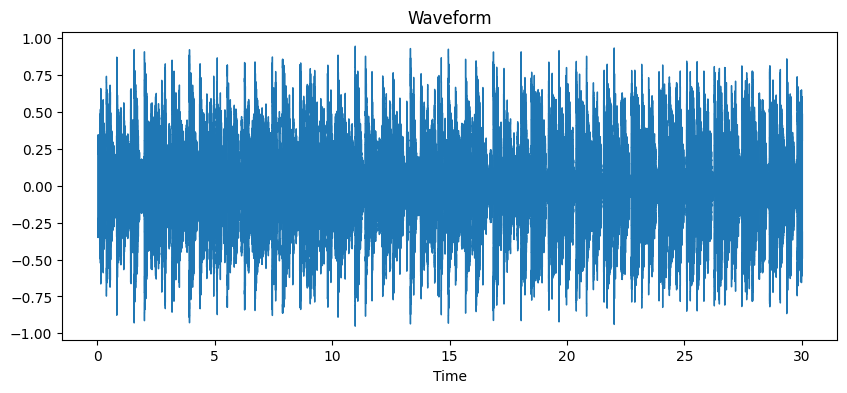

In [43]:
# load mp3 files to WAV using ffmpeg, view a file
y, sr = librosa.load('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/Music/happy/adana_kopru_basi_murat_kursun.mp3') # neutral song tested first '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/Music/neutral/alp_ersonmez_burada_yarali_biri_var.mp3'
show_audio(y, sr)


### Analyse the Grouping of Each Pre-Labelled Category

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


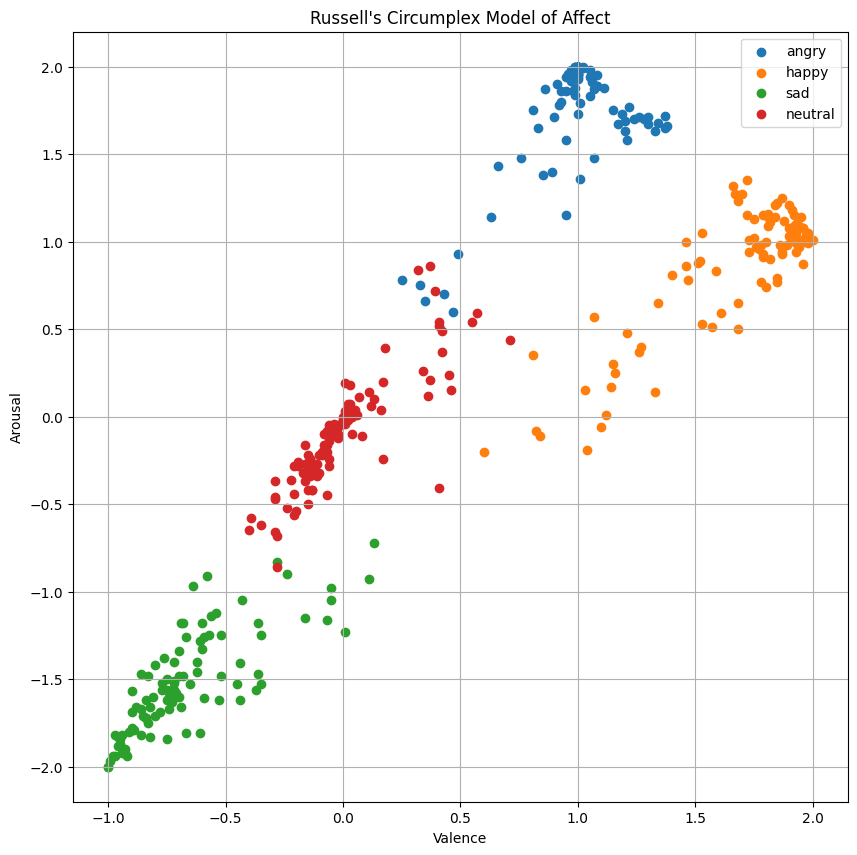

In [18]:
 # code debugged with GPT
music_folder = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/Music'

# Define a function to extract features, code adapted from: https://www.hackersrealm.net/post/extract-features-from-audio-mfcc-python#:~:text=Librosa%20is%20a%20Python%20package,x%2C%20sample_rate%20%3D%20librosa. 
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path)  # Load WAV 
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr) #estimates the tempo (beats per minute) of the audio.
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0) #computes the Mel-Frequency Cepstral Coefficients, which are used to represent the short-term power spectrum of sound.
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0) #computes the chroma feature, which represents the 12 different pitch classes.
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0) # measures the difference in amplitude between peaks and valleys in the spectrum.
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
        return np.hstack([tempo, mfccs, chroma, mel, contrast, tonnetz]) #computes the tonal centroid features, which are related to the harmonic content of the audio.
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Define the emotions you are working with
emotions = ['angry', 'happy', 'sad', 'neutral']

# Extract features for each song
data = [
    (emotion, extract_features(os.path.join(music_folder, emotion, file_name)))
    for emotion in emotions
    for file_name in os.listdir(os.path.join(music_folder, emotion))
    if file_name.endswith('.wav') and extract_features(os.path.join(music_folder, emotion, file_name)) is not None
]

# Separate features and labels
X = np.array([item[1] for item in data])
y = np.array([item[0] for item in data])

# Scale the features (required debugging with GPT)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP for dimensionality reduction. Code adapted from: https://www.kaggle.com/code/bextuychiev/beautiful-umap-tutorial-on-100-dimensional-data 
X_reduced = umap.UMAP(n_components=2).fit_transform(X_scaled)

# Map emotions to valence and arousal using RandomForestRegressor
valence_model = RandomForestRegressor()
arousal_model = RandomForestRegressor()

# Valence and arousal values for training
valence_values = {'angry': 1, 'happy': 2, 'sad': -1, 'neutral': 0}
arousal_values = {'angry': 2, 'happy': 1, 'sad': -2, 'neutral': 0}

y_valence = np.array([valence_values[emotion] for emotion in y])
y_arousal = np.array([arousal_values[emotion] for emotion in y])

valence_model.fit(X_reduced, y_valence)
arousal_model.fit(X_reduced, y_arousal)

valence_pred = valence_model.predict(X_reduced)
arousal_pred = arousal_model.predict(X_reduced)

# Plot the data
plt.figure(figsize=(10, 10))
for emotion in emotions:
    indices = [i for i, e in enumerate(y) if e == emotion]
    plt.scatter(valence_pred[indices], arousal_pred[indices], label=emotion)

plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.title("Russell's Circumplex Model of Affect")
plt.legend()
plt.grid(True)
plt.show()

### Manipulating Audio Values Accordig to Emotion 

In [19]:
#Focussing on manipulating a song's pitch and tempo based on predicted emotions, achieving this using the pre-labeled Turkish music dataset ( available from: https://www.kaggle.com/datasets/blaler/turkish-music-emotion-dataset)
def extract_features(file_path):
    y, sr = librosa.load(file_path)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    return mfccs

# Define the path to your music folder
music_folder = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/Music'
emotions = ['angry', 'happy', 'sad', 'neutral']

# Collect features and labels
features = []
labels = []

for emotion in emotions:
    folder_path = os.path.join(music_folder, emotion)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            features.append(extract_features(file_path))
            labels.append(emotion)

In [15]:
# Train Random Forest Classifier on musical elements for each emotional class
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a classifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Predict emotions
predicted_emotions = classifier.predict(X_test)

In [44]:
# The following code was created using librosa documentation (https://librosa.org/doc/main/generated/librosa.effects.time_stretch.html) and debugged with GPT where the output was not changing due to an error in the if, elif statements.
def manipulate_audio(file_path, emotion):
    y, sr = librosa.load(file_path)
    
   
    # Adjust tempo based on the emotional states from the graph above
    if emotion == 'happy':
        y_fast = librosa.effects.time_stretch(y, rate=1.5)  # Moderate speed up (valence ~ 1.5, arousal ~ 1.0 but ased on the higher energy and brightness in the Mel-Spectrogram (1024–4096 Hz)
    elif emotion == 'sad':
        y_fast = librosa.effects.time_stretch(y, rate=0.9)  # Moderate slow down (valence ~ -1.0, arousal ~ -1.5)
    elif emotion == 'angry':
        y_fast = librosa.effects.time_stretch(y, rate=1.5)  # Significant speed up (valence ~ 0.5, arousal ~ 2.0)
    else:  # Neutral
        y_fast = librosa.effects.time_stretch(y, rate=1.0)  # No change for neutral (centered values)

    # Adjust pitch and apply additional effects for "angry"
    if emotion == 'angry':
        y_shifted = librosa.effects.pitch_shift(y_fast, sr=sr, n_steps=5)  # Increase pitch due to high arousal
        y_shifted = np.tanh(y_shifted * 15)  # Add distortion for intensity
        y_shifted = librosa.effects.preemphasis(y_shifted, coef=1)  # Add EQ for harshness
    elif emotion == 'sad':
        y_shifted = librosa.effects.pitch_shift(y_fast, sr=sr, n_steps=-4)  # Decrease pitch due to low arousal
    else:
        y_shifted = y_fast  # No pitch change for happy or neutral

    return y_shifted, sr


# Example usage
example_file_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/Music/neutral/alp_ersonmez_burada_yarali_biri_var.mp3'
predicted_emotion = 'angry'  # Change the emotion of the song
y_modified, sr = manipulate_audio(example_file_path, predicted_emotion)

# Save the modified audio using soundfile
sf.write('modified_song_happy_to_angry.wav', y_modified, sr)

# Analyse the Sampled Song for Audio Changes 

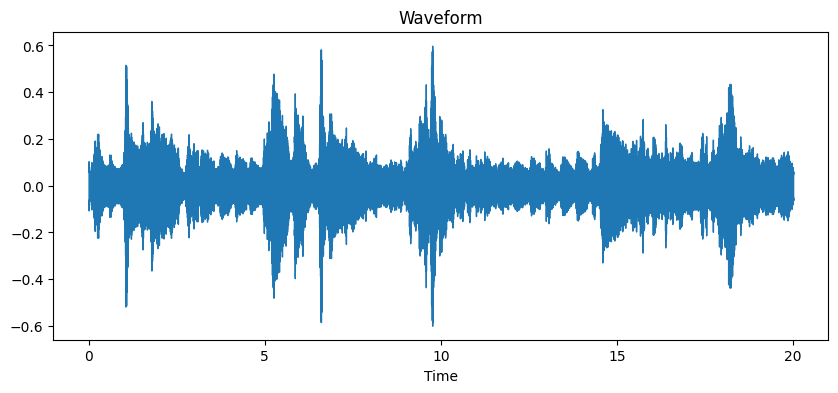

In [46]:
# View wav format of manipulated song. What difference did this make?
y, sr = librosa.load('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/modified_song_happy_to_angry.wav')#'/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/modified_song_angry.wav'
show_audio(y, sr)
#print("Happy song modified to sound angry")

### Understanding the Features within Each MP3 File

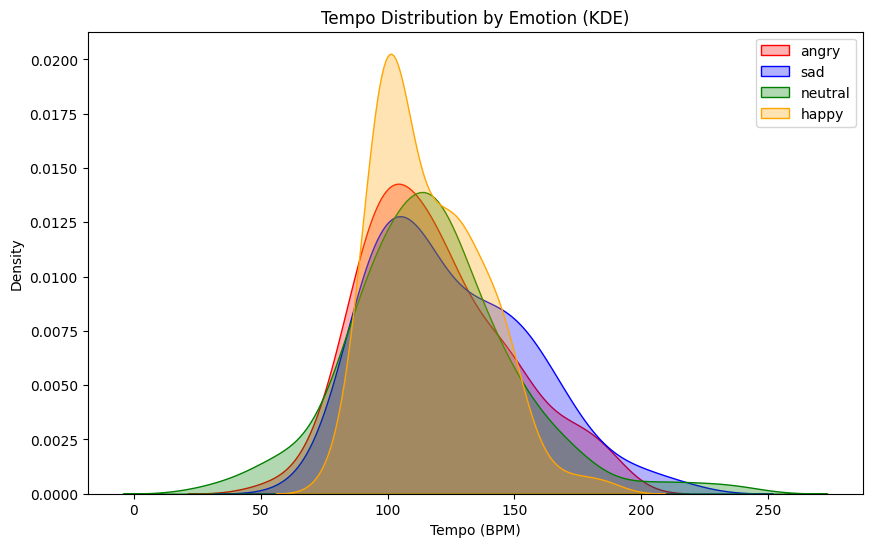

In [35]:
base_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/Music'
emotions = ['angry', 'sad', 'neutral', 'happy']

# Function to extract features from a music file
def extract_features(file_path):
    y, sr = librosa.load(file_path)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return {
        'tempo': np.mean(tempo),  # Use the mean if multiple tempo values are returned
        'mfccs_mean': np.mean(mfccs, axis=1),
        'mfccs_std': np.std(mfccs, axis=1)
    }

# Initialize a list to store features
features_list = []

# Iterate over each emotion directory
for emotion in emotions:
    emotion_path = os.path.join(base_path, emotion)
    for file_name in os.listdir(emotion_path):
        if file_name.endswith('.wav'):  # Assuming your files are in .wav format
            file_path = os.path.join(emotion_path, file_name)
            features = extract_features(file_path)
            features['emotion'] = emotion
            features_list.append(features)

# Convert the list of features to a DataFrame
features_df = pd.DataFrame(features_list)

# Save the features to a CSV file for further analysis
features_df.to_csv('music_features.csv', index=False)

# Visualize the tempo distribution for each emotion
# Visualize the tempo distribution for each emotion using KDE plots
plt.figure(figsize=(10, 6))

# Define a color map for the emotions
colors = ['red', 'blue', 'green', 'orange']

for emotion, color in zip(emotions, colors):
    subset = features_df[features_df['emotion'] == emotion]
    sns.kdeplot(subset['tempo'], label=emotion, color=color, fill=True, alpha=0.3)

plt.xlabel('Tempo (BPM)')
plt.ylabel('Density')
plt.title('Tempo Distribution by Emotion (KDE)')
plt.legend(loc='upper right')
plt.show()



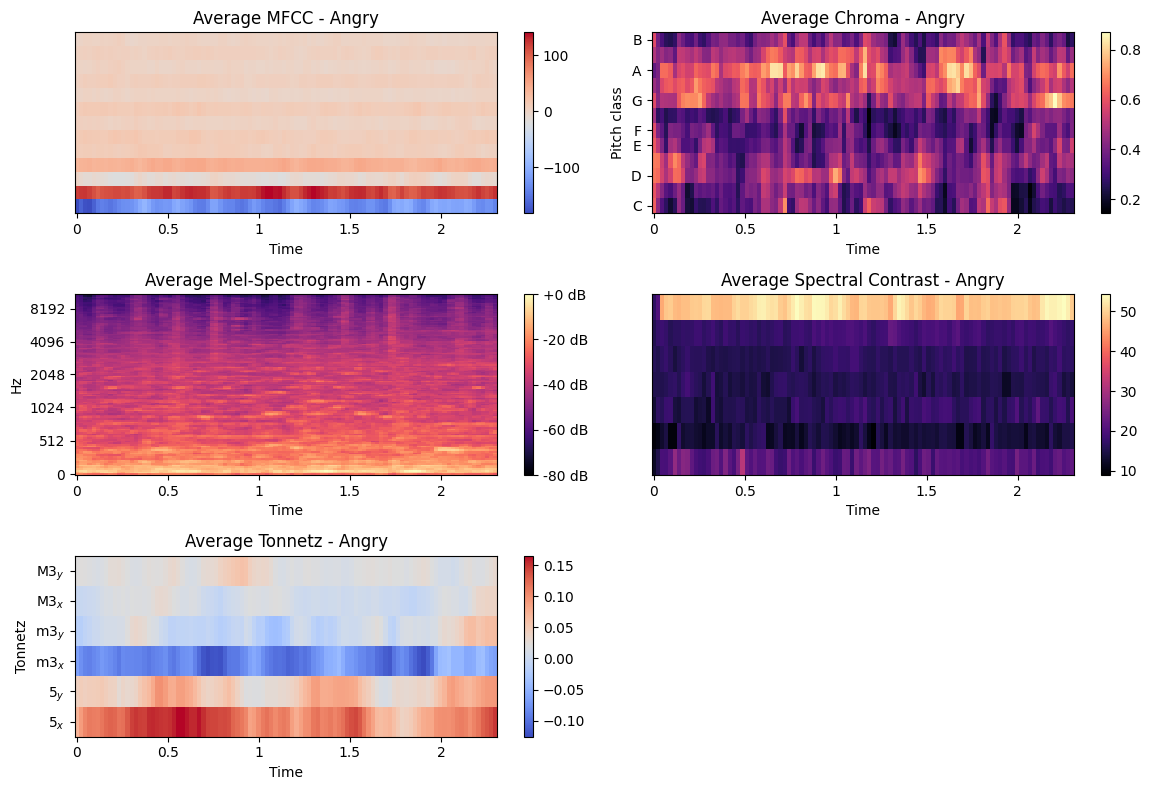

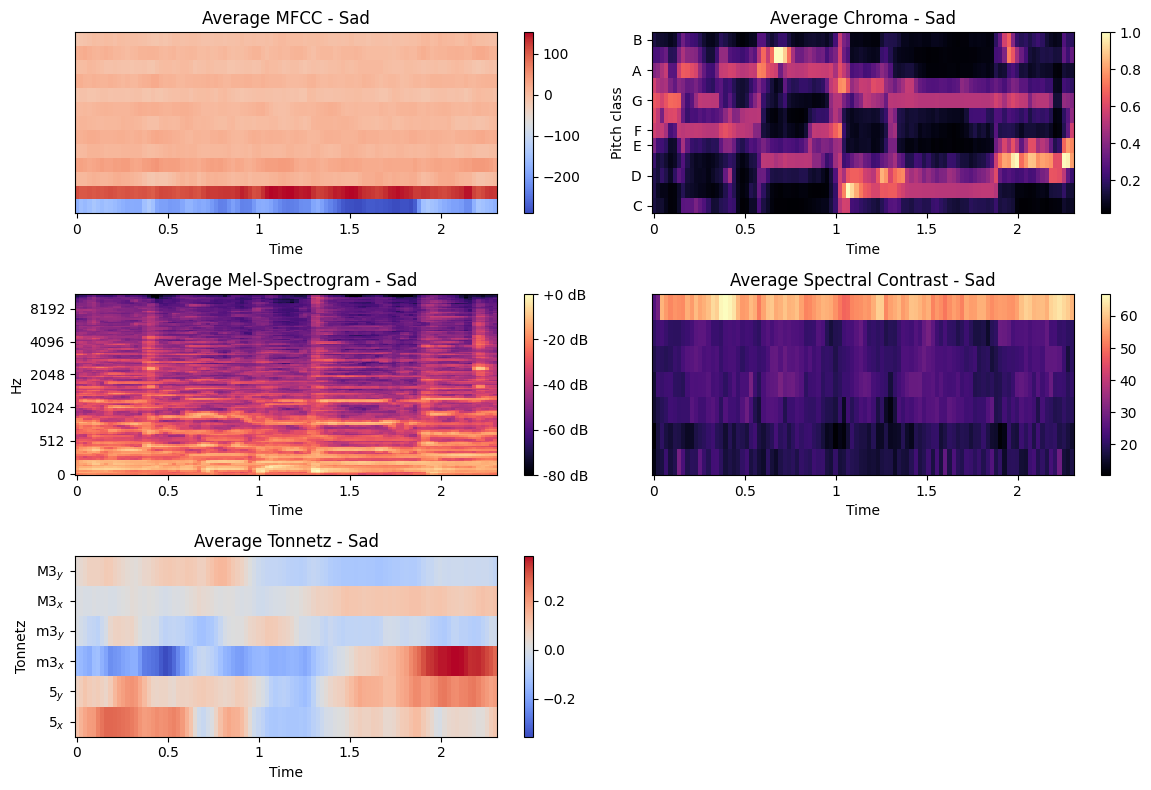

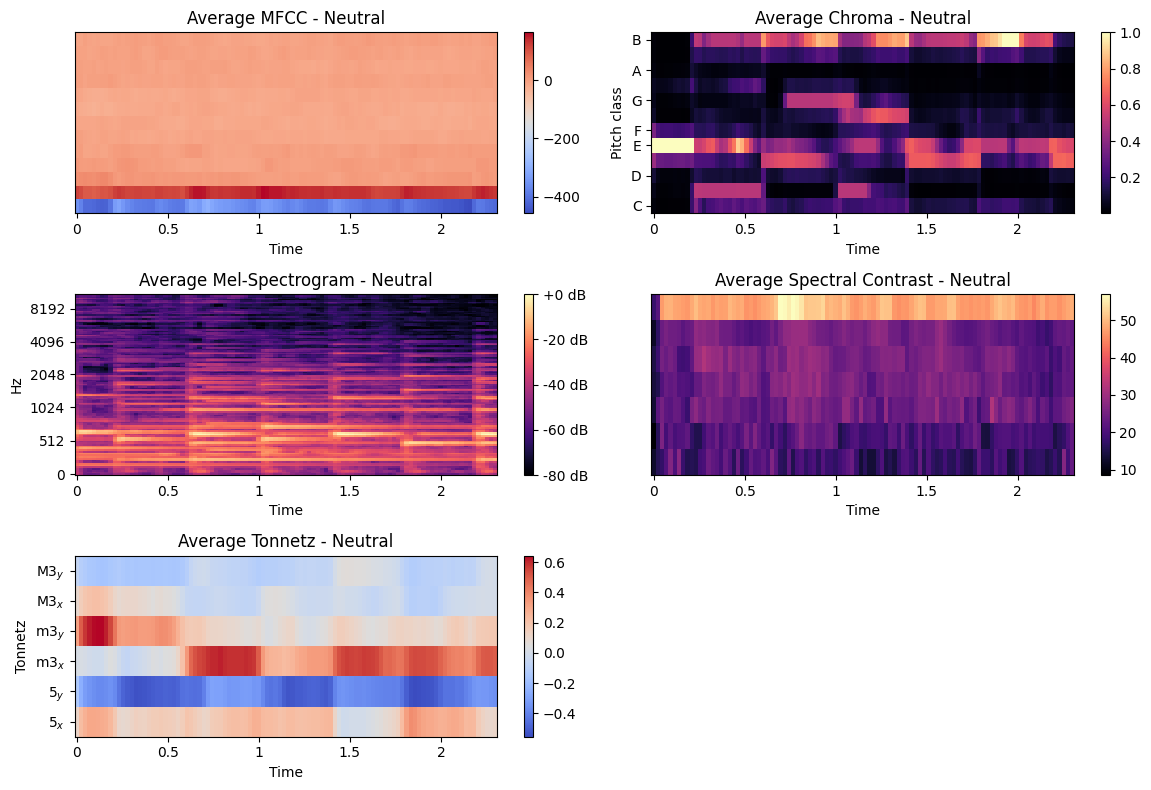

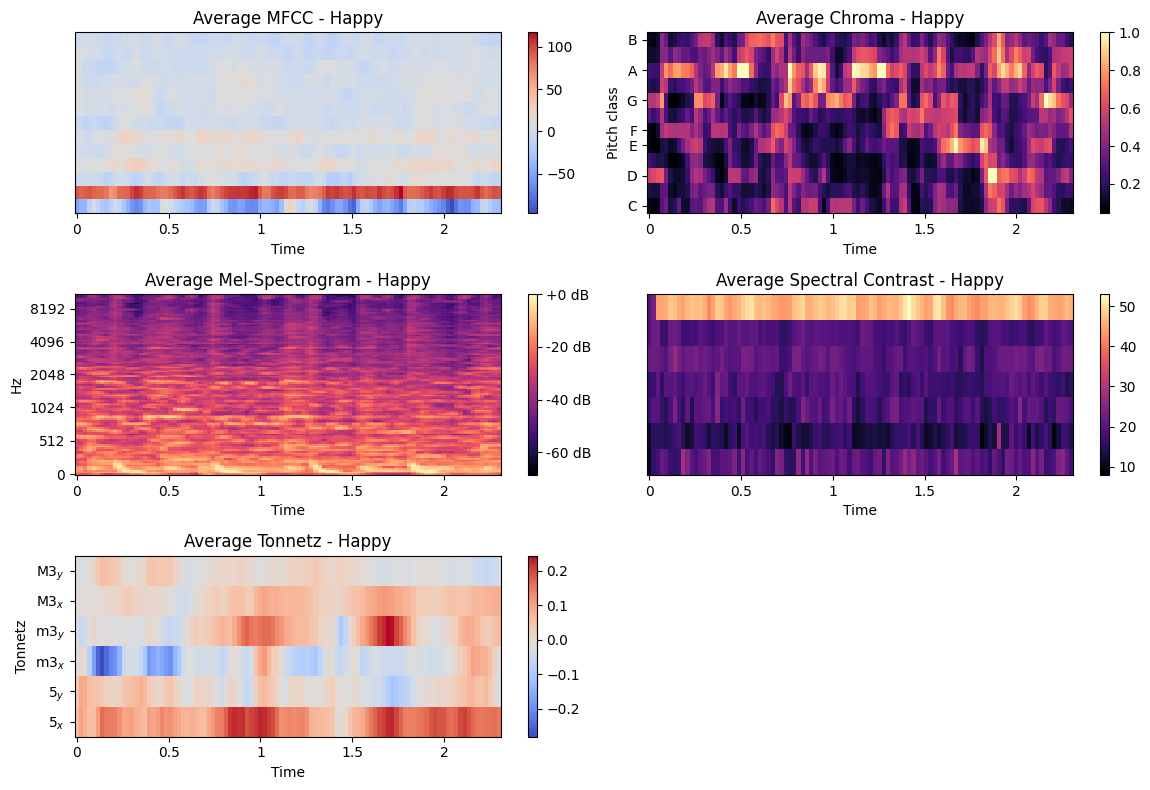

In [40]:
# Debugged using GPT where the attempt to compute the mean of arrays was not viable due to inconsistent shapes from feature extraction.
base_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/Music'
emotions = ['angry', 'sad', 'neutral', 'happy']

# Function to extract features from a music file
def extract_features(file_path, n_mfcc=13, n_chroma=12, n_mel=128, n_contrast=7, n_tonnetz=6, fixed_length=100):
    y, sr = librosa.load(file_path)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    
    # Extract features, code adapted from : https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html documentation
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    
    # List features
    mfccs = librosa.util.fix_length(mfccs, size=fixed_length, axis=1)
    chroma = librosa.util.fix_length(chroma, size=fixed_length, axis=1)
    mel_spectrogram = librosa.util.fix_length(mel_spectrogram, size=fixed_length, axis=1)
    spectral_contrast = librosa.util.fix_length(spectral_contrast, size=fixed_length, axis=1)
    tonnetz = librosa.util.fix_length(tonnetz, size=fixed_length, axis=1)
    
    return {'tempo': np.mean(tempo),
        'mfccs': mfccs,
        'chroma': chroma,
        'mel_spectrogram': mel_spectrogram,
        'spectral_contrast': spectral_contrast,
        'tonnetz': tonnetz}

# Iterate over each emotion directory
for emotion in emotions:
    emotion_path = os.path.join(base_path, emotion)
    features_list = []
    
    # Process the first 5 files
    for i, file_name in enumerate(os.listdir(emotion_path)):
        if i >= 5:
            break
        if file_name.endswith('.wav'):
            file_path = os.path.join(emotion_path, file_name)
            features = extract_features(file_path)
            features_list.append(features)
    
    # Calculate the average features of all mp3s for each emotional class within the music folder directory
    avg_features = {
        'tempo': np.mean([f['tempo'] for f in features_list]),
        'mfccs': np.mean([f['mfccs'] for f in features_list], axis=0),
        'chroma': np.mean([f['chroma'] for f in features_list], axis=0),
        'mel_spectrogram': np.mean([f['mel_spectrogram'] for f in features_list], axis=0),
        'spectral_contrast': np.mean([f['spectral_contrast'] for f in features_list], axis=0),
        'tonnetz': np.mean([f['tonnetz'] for f in features_list], axis=0)}
    
    # Plot average features
    plt.figure(figsize=(12, 8))
    
    # Plot MFCCs
    plt.subplot(3, 2, 1)
    librosa.display.specshow(avg_features['mfccs'], x_axis='time', sr=sr)
    plt.colorbar()
    plt.title(f'Average MFCC - {emotion.capitalize()}')
    
    # Plot Chroma
    plt.subplot(3, 2, 2)
    librosa.display.specshow(avg_features['chroma'], y_axis='chroma', x_axis='time', sr=sr)
    plt.colorbar()
    plt.title(f'Average Chroma - {emotion.capitalize()}')
    
    # Plot Mel-Spectrogram
    plt.subplot(3, 2, 3)
    librosa.display.specshow(librosa.power_to_db(avg_features['mel_spectrogram'], ref=np.max), y_axis='mel', x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Average Mel-Spectrogram - {emotion.capitalize()}')
    
    # Plot Spectral Contrast
    plt.subplot(3, 2, 4)
    librosa.display.specshow(avg_features['spectral_contrast'], x_axis='time', sr=sr)
    plt.colorbar()
    plt.title(f'Average Spectral Contrast - {emotion.capitalize()}')
    
    # Plot Tonnetz
    plt.subplot(3, 2, 5)
    librosa.display.specshow(avg_features['tonnetz'], y_axis='tonnetz', x_axis='time', sr=sr)
    plt.colorbar()
    plt.title(f'Average Tonnetz - {emotion.capitalize()}')
    
    plt.tight_layout()
    plt.show()